In [3]:
!pip install rouge_score
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import T5Tokenizer,  TFAutoModelForSeq2SeqLM, create_optimizer
from wordcloud import WordCloud
import re
import unicodedata
import tensorflow as tf
from sklearn.model_selection import train_test_split
import gc
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

In [4]:
# load and display the dataset from hugging face
data = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Bitext_Sample_Customer_Support_Training_(…):   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})

# Overview of the Dataset

This hybrid synthetic dataset is designed to be used to fine-tune Large Language Models such as GPT, Mistral and OpenELM, and has been generated using  NLP/NLG technology and our automated Data Labeling (DAL) tools.

## Dataset Specifications

* **Use Case:** Intent Detection
* **Vertical:** Customer Service
* **Intents:** 27 intents assigned to 10 categories
* **Dataset Size:** 26,872 question/answer pairs, around 1,000 per intent
* **Entity Types:** 30 entity/slot types
* **Language Tags:** 12 different types of language generation tags

## Categories and Intents

The categories and intents have been selected from Bitext's collection of 20 vertical-specific datasets, covering the intents that are common across all 20 verticals.

### Verticals Covered:
* Automotive
* Retail Banking
* Education
* Events & Ticketing
* Field Services
* Healthcare
* Hospitality
* Insurance
* Legal Services
* Manufacturing
* Media Streaming
* Mortgages & Loans
* Moving & Storage
* Real Estate/Construction
* Restaurant & Bar Chains
* Retail/E-commerce
* Telecommunications
* Travel
* Utilities
* Wealth Management

## Generation Methodology

The question/answer pairs have been generated using a hybrid methodology that uses natural texts as source text, NLP technology to extract seeds from these texts, and NLG technology to expand the seed texts. All steps in the process are curated by computational linguists.

In [5]:
# change the data format to pandas for easier manipulation and analysis
data.set_format(type='pandas')

# Extract the train set and display the first five rows
df = data['train'][:]
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


# Data Exploration

In [6]:
"""Basic Inspection"""

# Simple overview of the dataset showing the number of columns, null values and data types for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26872 entries, 0 to 26871
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   flags        26872 non-null  object
 1   instruction  26872 non-null  object
 2   category     26872 non-null  object
 3   intent       26872 non-null  object
 4   response     26872 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [7]:
"""Missing Data Analysis"""

# confirm number of null values for each column
def check_missing_values(dataframe):
  print("Missing Values per column:\n")
  print(dataframe.isnull().sum())
  print("\n")
  # Check for empty strings in the data
  empty_instructions = (dataframe['instruction'].str.strip() == '').sum()
  empty_responses = (dataframe['response'].str.strip() == '').sum()
  print(f"Number of empty strings in instructions column: {empty_instructions}")
  print(f"Number of empty strings in  responses column: {empty_responses}")

check_missing_values(df)

Missing Values per column:

flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64


Number of empty strings in instructions column: 0
Number of empty strings in  responses column: 0


In [8]:
"""Duplicate detection"""

# check for duplicated rows to prevent training bias
def check_duplicates(df):
  print(f"Number of duplicate rows: {df.duplicated().sum()}")

check_duplicates(df)

Number of duplicate rows: 0


In [9]:
# set figsize for matplotlib graphs
plt.rcParams['figure.figsize'] = (12, 6)

===== Category Distribution =====

category
ACCOUNT         5986
ORDER           3988
REFUND          2992
CONTACT         1999
INVOICE         1999
PAYMENT         1998
FEEDBACK        1997
DELIVERY        1994
SHIPPING        1970
SUBSCRIPTION     999
CANCEL           950
Name: count, dtype: int64




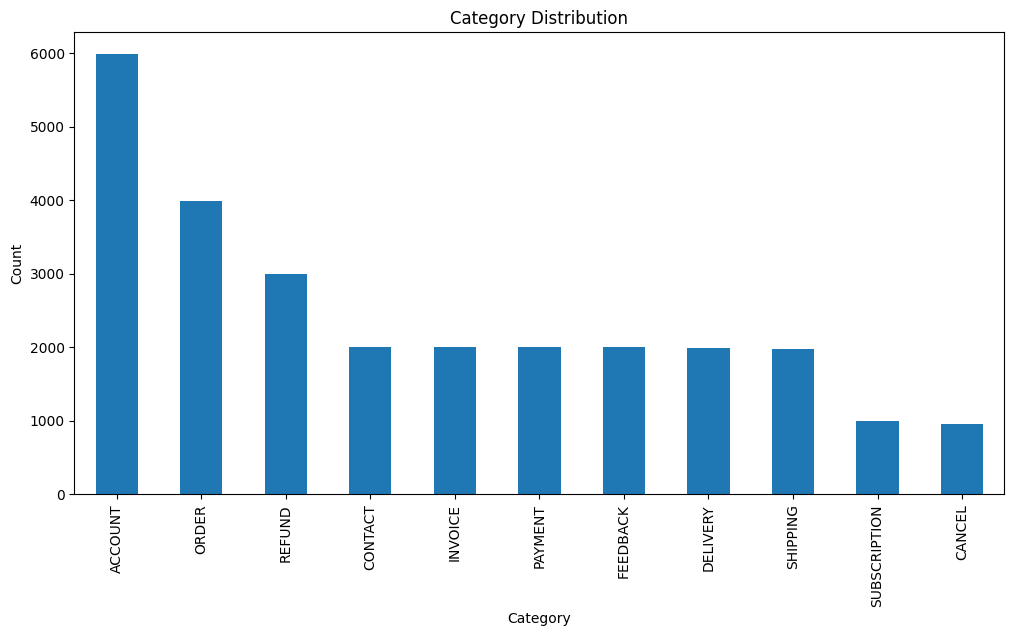

===== Intent Distribution =====

intent
contact_customer_service    1000
complaint                   1000
check_invoice               1000
switch_account              1000
edit_account                1000
contact_human_agent          999
check_payment_methods        999
delivery_period              999
newsletter_subscription      999
get_invoice                  999
payment_issue                999
registration_problems        999
cancel_order                 998
place_order                  998
track_refund                 998
change_order                 997
set_up_shipping_address      997
check_refund_policy          997
create_account               997
get_refund                   997
review                       997
delivery_options             995
delete_account               995
recover_password             995
track_order                  995
change_shipping_address      973
check_cancellation_fee       950
Name: count, dtype: int64




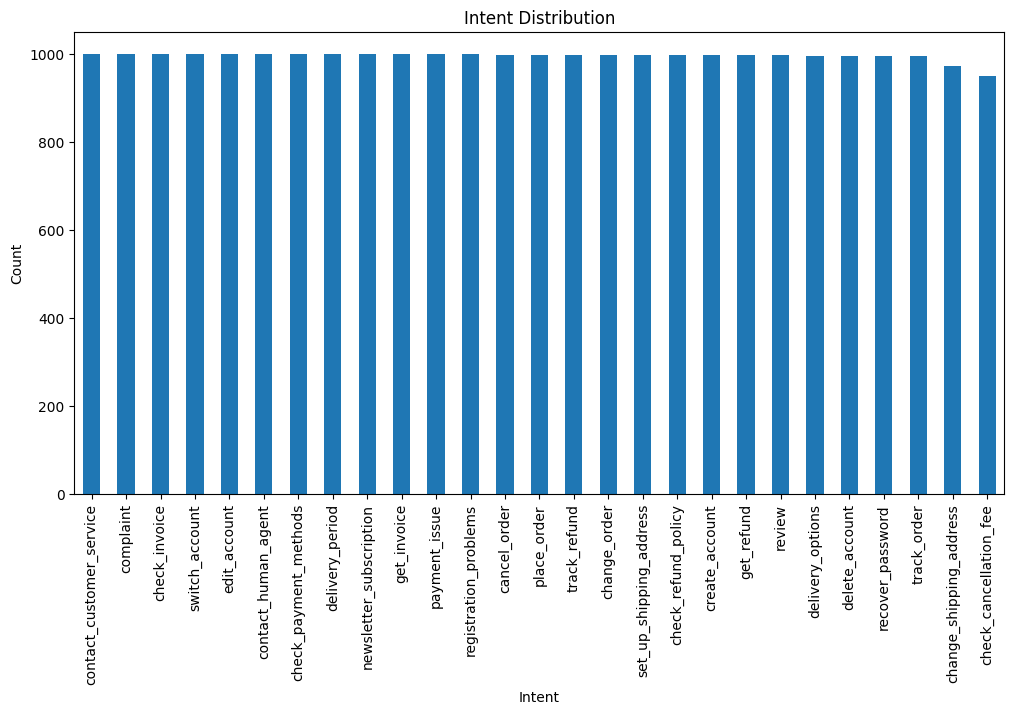

In [10]:
"""Category and Intent Analysis"""


def check_distribution(df, column:str, xlabel:str, ylabel:str, title:str):
  # Display distribution of categories in the data
  distribution = df[column].value_counts()
  print(f"===== {title} =====\n")
  print(distribution)
  print("\n")
  # plot category distribution
  distribution.plot.bar()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()



check_distribution(df, 'category', 'Category', 'Count', 'Category Distribution')
check_distribution(df, 'intent', 'Intent', 'Count', 'Intent Distribution')

In [11]:
"""Text Length Analysis"""

# character count for instruction and response columns
df['instruction_length'] = df['instruction'].str.len()
df['response_length'] = df['response'].str.len()

# word counts for instruction and response columns
df['instruction_word_count'] = df['instruction'].str.split().str.len()
df['response_word_count'] = df['response'].str.split().str.len()


# display character length statistics for instructions and words
print("\n--- Character Length Statistics ---")
print("\nInstructions:")
print(df['instruction_length'].describe())
print("\nResponses:")
print(df['response_length'].describe())

# display character length statistics for instructions and words
print("\n--- Word Count Statistics ---")
print("\nInstructions:")
print(df['instruction_word_count'].describe())
print("\nResponses:")
print(df['response_word_count'].describe())


--- Character Length Statistics ---

Instructions:
count    26872.000000
mean        46.889513
std         10.897578
min          6.000000
25%         40.000000
50%         48.000000
75%         55.000000
max         92.000000
Name: instruction_length, dtype: float64

Responses:
count    26872.000000
mean       634.104495
std        331.593822
min         57.000000
25%        427.000000
50%        540.000000
75%        753.000000
max       2472.000000
Name: response_length, dtype: float64

--- Word Count Statistics ---

Instructions:
count    26872.000000
mean         8.690979
std          2.605004
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         16.000000
Name: instruction_word_count, dtype: float64

Responses:
count    26872.000000
mean       104.789037
std         52.966204
min          9.000000
25%         72.000000
50%         90.000000
75%        124.000000
max        402.000000
Name: response_word_count, dtype: float64


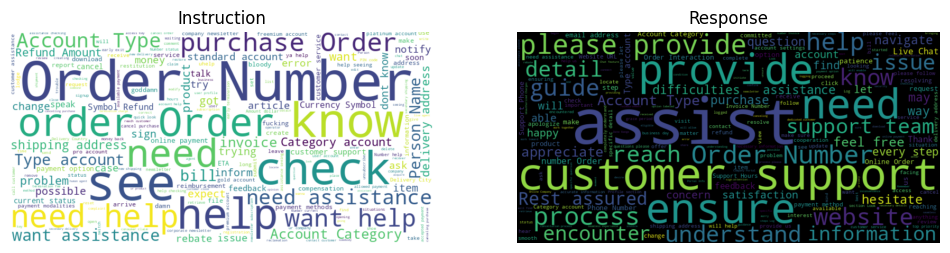

In [12]:
"""Vocabulary Wordcloud"""

# Word Clouds for Positive vs Negative Reviews
instruction_text = " ".join(df["instruction"].values)
response_text = " ".join(df['response'].values)

instruction_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(instruction_text)
response_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(response_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(instruction_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Instruction")

plt.subplot(1,2,2)
plt.imshow(response_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Response")
plt.show()

In [13]:
"""Data Quality Check for corrupt or malformed data"""

# check for Very short texts
short_instructions = (df['instruction'].str.split().str.len() < 3).sum() # less than 3 words in the instruction
short_responses = (df['response'].str.split().str.len() < 5).sum()       # less than 5 words in the response
print(f"\n1. Very short texts:")
print(f"   Instructions < 3 words: {short_instructions}")
print(f"   Responses < 5 words: {short_responses}")

# check for Special characters (excluding placeholders)
def has_unusual_chars(text):
    text_no_placeholders = re.sub(r'\{\{[^}]+\}\}', '', text)   # exclude plaholders in {{.....}} format
    return bool(re.search(r'[^\w\s.,!?\'-]', text_no_placeholders)) #  check for specialcharacters that aren't defined by the regex

# display number of unusual characters
unusual_instructions = df['instruction'].apply(has_unusual_chars).sum()
unusual_responses = df['response'].apply(has_unusual_chars).sum()
print(f"\n3. Unusual characters (non-standard):")
print(f"   Instructions: {unusual_instructions}")
print(f"   Responses: {unusual_responses}")


1. Very short texts:
   Instructions < 3 words: 104
   Responses < 5 words: 0

3. Unusual characters (non-standard):
   Instructions: 1038
   Responses: 10868


In [14]:
"""Display unusual characters that may potentially break training"""
# Find specific unusual characters
def find_unusual_chars(text):
    text_no_placeholders = re.sub(r'\{\{[^}]+\}\}', '', text)
    unusual = set(re.findall(r'[^\w\s.,!?\'-]', text_no_placeholders))
    return unusual

# Unusual characters in responses
def print_unusual_characters(column):
  all_unusual = set()
  for text in df[column]:
      all_unusual.update(find_unusual_chars(text))
  print(f"Unusual characters in {column}: {sorted(all_unusual)}\n\n")



print_unusual_characters('instruction')
print_unusual_characters('response')




Unusual characters in instruction: ['#', '$']


Unusual characters in response: ['"', '#', '$', '&', '(', ')', '*', '+', '/', ':', ';', '>', '@', '[', ']', '`', '{', '}', '¡', '–', '—', '’', '☺', '✨', '️', '🌟', '👍', '💡', '💪', '🔐', '🔒', '🗝', '😊', '🙁', '🙏', '🛡', '🤗', '🤝']




# Key Insights and decisions from data analysis

1. **Basic Inspection** - There is no null data in the the dataset so there will be no need for handling null data in preprocessing

2. **Missing Data Analysis** -  Confirm no null data, and also confirms that there are no empty strings in the dataset.

3. **Duplicate detection**  - No duplicates in the dataset, therefore no need for handling duplicates in preprocessing.

4. **Category and Intent Analysis** - There was some imbalance in the category distribution with the most common category "ACCOUNT" CONSISTIG OF 22% of the data and the least common "CANCEL" accounting for 3.5%, thus, there is an imbalance ratio of  6.3x difference. The intent category however, has much less imbalance. Each of the 27 intents has ~ 1000 instructions with the lowest being 950.

    **Insight:** Use a stratified split for intents during training and validation

5. **Text Length Analysis** - Customer instructions average around 8-10 words, while agent responses are significantly longer, averaging 105 words. The distribution shows most instructions fall between 7-11 words and responses between 72-124 words.

    **Insight:** These patterns inform tokenizer configuration: setting **MAX_INPUT_LENGTH=128 tokens** which should cover all the instructions,  while **MAX_OUTPUT_LENGTH=512** tokens accommodates the longer, more detailed responses without unnecessary padding or information loss and also accomodates the max word count of 402 words.


6. **Data Quality Check:** 6. **Data Quality Check:** About 104 examples have instructions with less than 3 words, 1,038 instructions contain unusual characters[#, '$'], and 10,868 responses (40% of dataset) contain special characters including ['"', '#', '$', '&', '(', ')', '*', '+', '/', ':', ';', '>', '@', '[', ']', '`', '{', '}', '¡', '–', '—', ''', '☺', '✨', '️', '🌟', '👍', '💡', '💪', '🔐', '🔒', '🗝', '😊', '🙁', '🙏', '🛡', '🤗', '🤝'].

    **Insight:** Remove the 104 short instructions as they represent only 0.4% of the dataset and are likely incomplete queries. For special characters, normalize double quotes to single (" to '), weird apostrophes to consistent ones  (` to '), and double dashes to single (—– to -) for consistency. Keep functional characters like '$', '#', '@', '()', and ':' as they're used for prices, order numbers, emails, and formatting. Emojis can be retained as they add warmth and approachability to customer service responses.The tokenizer will handle them appropriately during encoding.
  


# Data Preprocessing

## Preprocessing Steps NOT Needed for FLAN-T5

Modern transformer models like FLAN-T5 are designed to learn from minimally processed text. The following traditional NLP preprocessing steps are **unnecessary and can actually hurt performance**:

1. **Lowercasing** - The model learns that capitalization carries meaning (e.g., "ORDER" vs "order" may indicate urgency or emphasis). Lowercasing removes this signal.

2. **Removing Punctuation** - Punctuation conveys tone and meaning ("Help!" vs "Help." vs "Help?"). The model uses these cues for context.

3. **Removing Stopwords** - Words like "the", "a", "is" are crucial for grammar and sentence structure. Removing them breaks natural language patterns.

4. **Stemming/Lemmatization** - Converting "running" → "run" is unnecessary as the model's subword tokenizer already handles word variations and morphology.

5. **Removing Numbers** - Numbers are important in customer service (order IDs, amounts, dates). The model needs to learn when and how to use them.

6. **Aggressive Special Character Removal** - Characters like $, #, @, (), : have semantic meaning (prices, tags, emails, phone numbers). Keep them.

**What You DO Need:**
- Unicode normalization (NFKC) for consistency
- Remove extra whitespace
- Remove control characters
- Drop incomplete examples (<3 words)
- Normalizing punctuations into a standard format

**Philosophy:** FLAN-T5's tokenizer and architecture are designed to handle raw, natural text. Over-preprocessing removes information the model can learn from, reducing its ability to understand context and nuance.

In [15]:
# normalize tokens that may cause the trainining in the model to break, most unusual tokens are valid tokens just not included in the regex for bypassing them.

# normalizes all punctuations to standard form automatically
def normalize_special_chars(text):
    """Normalize unicode to standard form"""
    # NFKC handles most quote/dash normalization automatically
    text = unicodedata.normalize('NFKC', text)
    text = ''.join(char for char in text
               if unicodedata.category(char)[0] != 'C'  # Remove control chars that are invisible to the human eye but confuse models, eg null bytes, form feeds etc.
               or char in '\n\t ') # allow new lines and tabs

    return text

In [16]:
def remove_extra_whitespace(text):
    # Remove extra whitespace in data
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [17]:
# function to clean and normalize the data
def clean_and_normalize(df):

  # normalize unicode characters in the dats
  df['instruction_clean'] = df['instruction'].apply(normalize_special_chars)
  df['response_clean'] = df['response'].apply(normalize_special_chars)

  # remove really short instructions and responses
  initial_rows = df.shape[0]
  df = df[df['instruction_clean'].str.split().str.len() >= 3] # remove intructions less than 3 words
  df = df[df['response_clean'].str.split().str.len() >= 5]    # remove responses less than 5 words
  final_rows = df.shape[0]
  print(f"Removed {initial_rows - final_rows} rows\n")
  print(f"New Shape: {df.shape}\n")

  # remove extra white space to ensure consistent spacing in the data
  df['instruction_clean'] = df['instruction_clean'
  ].apply(remove_extra_whitespace)
  df['response_clean']= df['response_clean'].apply(remove_extra_whitespace)

  return df

df_clean = clean_and_normalize(df)

Removed 104 rows

New Shape: (26768, 11)



In [18]:
# Create sentence pairs to match the desired input of the model
def create_sentence_pairs(df):
  sentence_pairs = []
  for index, row in df.iterrows():
      instruction = row['instruction_clean']
      response = row['response_clean']

      input_text = f"Answer the customer service query: {instruction}" # add prefix describin gquery because modelwas trained using data in this structure
      output_text = response


      sentence_pairs.append({
              'input': input_text,
              'output': output_text
          })
  return sentence_pairs

sentence_pairs = create_sentence_pairs(df_clean)
sentence_pairs[0:2]


[{'input': 'Answer the customer service query: question about cancelling order {{Order Number}}',
  'output': "I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you."},
 {'input': 'Answer the customer service query: i have a question about cancelling oorder {{Order Number}}',
  'output': "I've been informed that you have a question about canceling order {{Order Number}}. I'm here to assist you! Please go ahead and let me know what specific question you have, and I'll provide you with all the information and guidance you need. Your satisfaction is my top priority."}]

In [19]:
MAX_LENGTH = 512 # max lenth for model responses

# Initialize google flan t5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
print(f"Vocab size: {tokenizer.vocab_size}")

def tokenize_data(sentence_pairs):
    inputs = [pair['input'] for pair in sentence_pairs]
    outputs = [pair['output'] for pair in sentence_pairs]

    # This tokenizes both input and target together
    model_inputs = tokenizer(
        inputs,
        text_target=outputs,
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="tf",
    )

    #  Mask padding tokens in labels with -100 instead of 0 to exclude them from loss computation
    labels = model_inputs['labels'].numpy()
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs['labels'] = tf.constant(labels)

    return model_inputs

# tokenize the sentence pairs
model_inputs = tokenize_data(sentence_pairs)
model_inputs


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Vocab size: 32000


{'input_ids': <tf.Tensor: shape=(26768, 512), dtype=int32, numpy=
array([[11801,     8,   884, ...,     0,     0,     0],
       [11801,     8,   884, ...,     0,     0,     0],
       [11801,     8,   884, ...,     0,     0,     0],
       ...,
       [11801,     8,   884, ...,     0,     0,     0],
       [11801,     8,   884, ...,     0,     0,     0],
       [11801,     8,   884, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(26768, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(26768, 512), dtype=int32, numpy=
array([[   27,    31,   162, ...,  -100,  -100,  -100],
       [   27,    31,   162, ...,  -100,  -100,  -100],
       [   27,    54,  1254, ...,  -100,  -100,  -100],
       ...,
       [    3, 23559,     6, ...,  -10

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert tensors to numpy arrays
input_ids = np.array(model_inputs['input_ids'])
attention_mask = np.array(model_inputs['attention_mask'])
labels = np.array(model_inputs['labels'])

# Split data
intents = df_clean['intent'].values

train_inputs, val_inputs, train_attention, val_attention, train_labels, val_labels = train_test_split(
    input_ids,
    attention_mask,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=intents
)

# Create dicts
train_data = {
    'input_ids': train_inputs,
    'attention_mask': train_attention,
    'labels': train_labels
}

val_data = {
    'input_ids': val_inputs,
    'attention_mask': val_attention,
    'labels': val_labels
}



# Build Model

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!pip install evaluate
import evaluate
from tensorflow.keras import backend as K

# ======================================
# 🧪 Experiment configurations
# ======================================
experiments = [
    {"name": "Baseline", "lr": 5e-5, "batch_size": 8, "weight_decay": 0.01, "warmup_steps": 0, "epochs": 3},
    {"name": "Higher LR", "lr": 1e-4, "batch_size": 8, "weight_decay": 0.01, "warmup_steps": 0, "epochs": 3},
    {"name": "Small Batch", "lr": 3e-5, "batch_size": 4, "weight_decay": 0.01, "warmup_steps": 0, "epochs": 3},
    {"name": "Lower Weight Decay", "lr": 5e-5, "batch_size": 8, "weight_decay": 0.001, "warmup_steps": 0, "epochs": 3},
    {"name": "With Warmup", "lr": 5e-5, "batch_size": 8, "weight_decay": 0.01, "warmup_steps": 500, "epochs": 3},
]

# ======================================
# ⚙️ Utility functions
# ======================================
def clear_memory():
    """Aggressively clear GPU and system memory"""
    K.clear_session()
    gc.collect()
    try:
        tf.config.experimental.reset_memory_stats('GPU:0')
    except:
        pass

def calculate_perplexity(model, val_dataset, sample_batches=50):
    """Calculate approximate perplexity using a few batches"""
    losses = []
    for i, batch in enumerate(val_dataset.take(sample_batches)):
        outputs = model(batch, training=False)
        losses.append(outputs.loss.numpy())
    avg_loss = np.mean(losses)
    return np.exp(avg_loss)

def calculate_bleu_rouge(model, tokenizer, val_inputs, val_labels, num_samples=50, batch_size=8):
    """Faster BLEU & ROUGE using Hugging Face evaluate"""
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")

    preds, refs = [], []
    num_samples = min(num_samples, len(val_inputs))

    for start in range(0, num_samples, batch_size):
        end = start + batch_size
        batch_inputs = val_inputs[start:end]
        generated = model.generate(batch_inputs, max_length=128)

        for i, gen in enumerate(generated):
            pred_text = tokenizer.decode(gen, skip_special_tokens=True)
            ref_ids = val_labels[start + i][val_labels[start + i] != -100]
            ref_text = tokenizer.decode(ref_ids, skip_special_tokens=True)
            preds.append(pred_text)
            refs.append(ref_text)

    bleu = bleu_metric.compute(predictions=preds, references=[[r] for r in refs])
    rouge = rouge_metric.compute(predictions=preds, references=refs)

    return {
        "bleu": bleu["bleu"] * 100,
        "rouge1": rouge["rouge1"] * 100,
        "rouge2": rouge["rouge2"] * 100,
        "rougeL": rouge["rougeL"] * 100,
    }

# ======================================
# 💬 Default Fallback for Out-of-Domain Queries
# ======================================
def chatbot_response(model, tokenizer, query, max_length=128):
    """
    Generate chatbot response; handle out-of-domain (OOD) queries gracefully.
    """
    input_ids = tokenizer.encode(query, return_tensors="tf")
    output = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    # Simple fallback detection
    if len(response.strip()) < 5 or "I don't know" in response or "not sure" in response:
        return "I'm sorry, I’m not trained to answer that yet. Could you rephrase or ask something else?"

    return response

# ======================================
# 🚀 Run Experiments
# ======================================
results = []

for idx, config in enumerate(experiments):
    print(f"\n{'='*50}")
    print(f"Experiment {idx+1}/{len(experiments)}: {config['name']}")
    print('='*50)

    # Clear memory between experiments
    if idx > 0:
        print("Clearing memory from previous experiment...")
        clear_memory()

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices(train_data).shuffle(10000).batch(config['batch_size'])
    val_ds = tf.data.Dataset.from_tensor_slices(val_data).batch(config['batch_size'])

    # Load model
    print("Loading model...")
    model = TFAutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", from_pt=True)

    # Optimizer setup
    num_train_steps = len(train_ds) * config['epochs']
    optimizer, schedule = create_optimizer(
        init_lr=config['lr'],
        num_train_steps=num_train_steps,
        num_warmup_steps=config['warmup_steps'],
        weight_decay_rate=config['weight_decay']
    )
    model.compile(optimizer=optimizer)

    # Train model
    print("Training...")
    history = model.fit(train_ds, validation_data=val_ds, epochs=config['epochs'], verbose=1)

    # Evaluate metrics
    print("Calculating metrics...")
    perplexity = calculate_perplexity(model, val_ds)
    scores = calculate_bleu_rouge(model, tokenizer, val_inputs, val_labels)

    result = {
        'Experiment': config['name'],
        'LR': config['lr'],
        'Batch': config['batch_size'],
        'Weight Decay': config['weight_decay'],
        'Warmup': config['warmup_steps'],
        'Train Loss': f"{history.history['loss'][-1]:.4f}",
        'Val Loss': f"{history.history['val_loss'][-1]:.4f}",
        'Perplexity': f"{perplexity:.2f}",
        'BLEU': f"{scores['bleu']:.2f}",
        'ROUGE-1': f"{scores['rouge1']:.2f}",
        'ROUGE-2': f"{scores['rouge2']:.2f}",
        'ROUGE-L': f"{scores['rougeL']:.2f}",
    }
    results.append(result)

    # Save intermediate results
    pd.DataFrame(results).to_csv('/content/drive/MyDrive/chatbot_results_intermediate.csv', index=False)
    print("✓ Intermediate results saved")

    # Save best model so far
    if idx == 0 or float(result['Perplexity']) < min([float(r['Perplexity']) for r in results[:-1]]):
        best_path = f'/content/drive/MyDrive/chatbot_model_{config["name"].replace(" ", "_")}'
        model.save_pretrained(best_path)
        tokenizer.save_pretrained(best_path)
        print(f"✓ Best model saved: {best_path}")

    # Free memory
    del model, optimizer, train_ds, val_ds
    clear_memory()
    print(f"✓ Experiment {config['name']} complete\n")

# ======================================
# 📊 Final Results
# ======================================
results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("FINAL EXPERIMENT RESULTS")
print("="*50)
print(results_df.to_string(index=False))
results_df.to_csv('/content/drive/MyDrive/chatbot_final_results.csv', index=False)
print("\n✓ Final results saved to Drive")

# Example of chatbot use after training:
# response = chatbot_response(model, tokenizer, "Can I cancel my order?")
# print(response)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00

Experiment 1/5: Baseline
Loading model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected

Training...
Epoch 1/3
2677/2677 [==============================] - 830s 295ms/step - loss: 1.1953 - val_loss: 0.8432
Epoch 2/3
2677/2677 [==============================] - 781s 292ms/step - loss: 0.9403 - val_loss: 0.7771
Epoch 3/3
2677/2677 [==============================] - 780s 292ms/step - loss: 0.8859 - val_loss: 0.7600
Calculating metrics...


✓ Intermediate results saved
✓ Best model saved: /content/drive/MyDrive/chatbot_model_Baseline
✓ Experiment Baseline complete


Experiment 2/5: Higher LR
Clearing memory from previous experiment...
Loading model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Training...
Epoch 1/3
2677/2677 [==============================] - 824s 295ms/step - loss: 1.0750 - val_loss: 0.7706
Epoch 2/3
2677/2677 [==============================] - 782s 292ms/step - loss: 0.8426 - val_loss: 0.7132
Epoch 3/3
2677/2677 [==============================] - 783s 293ms/step - loss: 0.7877 - val_loss: 0.6960
Calculating metrics...
✓ Intermediate results saved
✓ Best model saved: /content/drive/MyDrive/chatbot_model_Higher_LR
✓ Experiment Higher LR complete


Experiment 3/5: Small Batch
Clearing memory from previous experiment...
Loading model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Training...
Epoch 1/3
5354/5354 [==============================] - 1035s 187ms/step - loss: 1.2257 - val_loss: 0.8635
Epoch 2/3
5354/5354 [==============================] - 988s 184ms/step - loss: 0.9660 - val_loss: 0.7951
Epoch 3/3
5354/5354 [==============================] - 988s 184ms/step - loss: 0.9118 - val_loss: 0.7776
Calculating metrics...
✓ Intermediate results saved
✓ Experiment Small Batch complete


Experiment 4/5: Lower Weight Decay
Clearing memory from previous experiment...
Loading model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Training...
Epoch 1/3
2677/2677 [==============================] - 823s 294ms/step - loss: 1.1946 - val_loss: 0.8426
Epoch 2/3
2677/2677 [==============================] - 780s 291ms/step - loss: 0.9397 - val_loss: 0.7766
Epoch 3/3
2677/2677 [==============================] - 780s 291ms/step - loss: 0.8855 - val_loss: 0.7595
Calculating metrics...
✓ Intermediate results saved
✓ Experiment Lower Weight Decay complete


Experiment 5/5: With Warmup
Clearing memory from previous experiment...
Loading model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Training...
Epoch 1/3
2677/2677 [==============================] - 825s 295ms/step - loss: 1.3089 - val_loss: 0.8562
Epoch 2/3
2677/2677 [==============================] - 783s 292ms/step - loss: 0.9512 - val_loss: 0.7816
Epoch 3/3
2677/2677 [==============================] - 783s 292ms/step - loss: 0.8903 - val_loss: 0.7631
Calculating metrics...
✓ Intermediate results saved
✓ Experiment With Warmup complete


FINAL EXPERIMENT RESULTS
        Experiment      LR  Batch  Weight Decay  Warmup Train Loss Val Loss Perplexity  BLEU ROUGE-1 ROUGE-2 ROUGE-L
          Baseline 0.00005      8         0.010       0     0.8859   0.7600       2.20 20.28   51.69   27.93   37.34
         Higher LR 0.00010      8         0.010       0     0.7877   0.6960       2.05 21.79   53.66   29.79   38.82
       Small Batch 0.00003      4         0.010       0     0.9118   0.7776       2.27 20.07   52.35   27.93   37.58
Lower Weight Decay 0.00005      8         0.001       0     0.8855   0.7595       2.19 19.42